## Instructor comments below in large text

PROBLEM 1: 
    
The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

We simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$.


In [5]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
'''
Part 1: Simulate from the mixture of gaussians
'''
def sampleMixtureGaussian(numSamples,alpha):
    samples = np.empty(numSamples)
    for counterSample in range(numSamples):
        #first sample a gaussian
        uniform = np.random.uniform(0,1)
        if uniform <= alpha:
            chosen = "gaussian1"
        else:
            chosen = "gaussian2"

        #then sample from that gaussian
        samples[counterSample] = norm.rvs(loc=gaussians[chosen][0],scale=gaussians[chosen][1])
    return samples

(array([ 39.,  87.,  12.,   1.,   0.,   0.,   0.,   3.,  31.,  27.]),
 array([  6.45022186,   6.85480939,   7.25939693,   7.66398447,
          8.06857201,   8.47315954,   8.87774708,   9.28233462,
          9.68692216,  10.09150969,  10.49609723]),
 <a list of 10 Patch objects>)

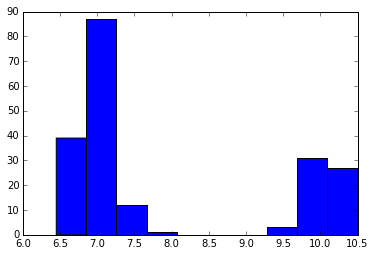

In [6]:
#define weights and the normal distributions
alpha = 0.7
gaussians = {'gaussian1':[7,0.5**2],'gaussian2':[10,0.5**2]}

#sample
numSamples = 200
originals = sampleMixtureGaussian(numSamples,alpha)
plt.hist(originals)

We implement an ABC procedure to simulate from the posterior distribution of $\delta$. The data sampled in the last part is treated as the original data for this part.

In [7]:
'''
Part 2: Approximate Bayesian Computation
'''
#Approximate Bayesian Computation params
tolerance = 0.15
alphaAccept = []

#discrepancy function
discrepancy = lambda originals,samples : (np.abs(sum(originals) - sum(samples)))/len(originals)

alphaSet = np.random.uniform(0,1,100000)
#repeat
iter=0
for alphaTest in alphaSet:     #simulate data
        
    iter+=1
    if iter%1000==0:
        print("Finished iterations " +str(iter))
    dataTest = sampleMixtureGaussian(numSamples,alphaTest)

    #check discrepancy
    e = discrepancy(originals,dataTest)
    
    #accept or reject
    if e < tolerance:
        alphaAccept.append(alphaTest)

predAlpha = sum(alphaAccept)/len(alphaAccept)
predAlpha

Finished iterations 1000
Finished iterations 2000
Finished iterations 3000
Finished iterations 4000
Finished iterations 5000
Finished iterations 6000
Finished iterations 7000
Finished iterations 8000
Finished iterations 9000
Finished iterations 10000
Finished iterations 11000
Finished iterations 12000
Finished iterations 13000
Finished iterations 14000
Finished iterations 15000
Finished iterations 16000
Finished iterations 17000
Finished iterations 18000
Finished iterations 19000
Finished iterations 20000
Finished iterations 21000
Finished iterations 22000
Finished iterations 23000
Finished iterations 24000
Finished iterations 25000
Finished iterations 26000
Finished iterations 27000
Finished iterations 28000
Finished iterations 29000
Finished iterations 30000
Finished iterations 31000
Finished iterations 32000
Finished iterations 33000
Finished iterations 34000
Finished iterations 35000
Finished iterations 36000
Finished iterations 37000
Finished iterations 38000
Finished iterations 3

0.69250957327883456

We find that the value found by ABC is very close to the actual value of 0.7

## It would be more useful to see the posterior distribution of delta, not just the point estimate

Next, we implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 

100000.0

 Iteration 0

 Iteration 10000

 Iteration 20000

 Iteration 30000

 Iteration 40000

 Iteration 50000

 Iteration 60000

 Iteration 70000

 Iteration 80000

 Iteration 90000
0.719360551035
Num accepted is 18319


/anaconda/envs/py3k/lib/python3.3/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/envs/py3k/lib/python3.3/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log


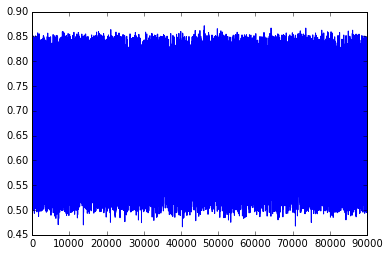

In [8]:
'''
Part 3: Metropolis Hastings
'''

from scipy.stats import distributions,uniform
import math
norm = distributions.norm.pdf
uniformSample = np.random.uniform

def calculatePosteriorLikelihood(alpha, x):
    likelihood = alpha*norm(x,gaussians["gaussian1"][0],gaussians["gaussian1"][1]) + \
                 (1-alpha)*norm(x,gaussians["gaussian2"][0],gaussians["gaussian2"][1])
    return np.sum(np.log(likelihood))

def metropolis(numIterations, initialValues, param):
    #number of parameters to estimate
    #numParams = len(initialValues)
    #trace for MCMC iterations
    trace = np.empty((numIterations+1))
    #update initial values
    trace[0] = initialValues
    #intialize acceptance counts
    accepted = 0
    #starting likelihood
    if param == "alpha":
        currLikelihood = calculatePosteriorLikelihood(initialValues,originals)
    elif param == "u":
        currLikelihood = calculatePosteriorLikelihood((np.exp(initialValues)/(1+np.exp(initialValues))),originals)

    #MCMC
    print(numIterations)
    for counterMCMC in range(int(numIterations)):
        if counterMCMC%10000==0: print("\n Iteration "+str(counterMCMC))

        #current param value
        currentParam = trace[counterMCMC]

        #propose new value
        proposalError = uniformSample(-1,1)
        proposal = currentParam + proposalError
        #updated likelihood
        if param == "alpha":
            proposedLikelihood = calculatePosteriorLikelihood(proposal,originals)
        elif param == "u":
            proposedLikelihood = calculatePosteriorLikelihood(np.exp(proposal)/(1+np.exp(proposal)),originals)

        #Accept?
        ratio = np.exp(proposedLikelihood - currLikelihood)
        criterion = np.random.rand()
        if math.isnan(ratio):
            trace[counterMCMC+1] = trace[counterMCMC]
            continue
        if ratio>criterion:#accept
            trace[counterMCMC+1] = proposal
            accepted+=1
        else:#reject
            trace[counterMCMC+1] = trace[counterMCMC]

    return trace,accepted

trace, accepted = metropolis(1e5,0.5,"alpha")
plt.plot(trace[10000:])
print(trace[-1])
print("Num accepted is " + str(accepted))

The answer received by random-walk MH is also very close to the original value (0.7) 

Next, we reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$ and implement a random walk chain in U-space. 

## Part 4 below is incorrect. It requires an entirely different M-H algorithm. 

100000.0

 Iteration 0

 Iteration 10000

 Iteration 20000

 Iteration 30000

 Iteration 40000

 Iteration 50000

 Iteration 60000

 Iteration 70000

 Iteration 80000

 Iteration 90000
0.850178551557
Num accepted is 72208


/anaconda/envs/py3k/lib/python3.3/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


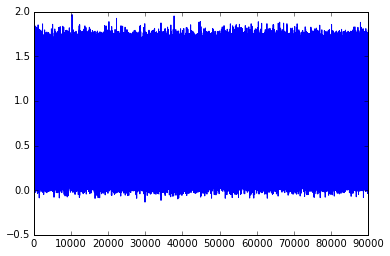

In [9]:
trace, accepted = metropolis(1e5,0,"u")
print(np.exp(trace[-1])/(1+np.exp(trace[-1])))
plt.plot(trace[10000:])
print("Num accepted is " + str(accepted))

We find that re-paratemterizing the problem in the log scale leads to a larger number of values being accepted. We run the iteration lesser number of times to see if convergence is indeed faster.

50000

 Iteration 0

 Iteration 10000

 Iteration 20000

 Iteration 30000

 Iteration 40000
0.805233681524
Num accepted is 36164


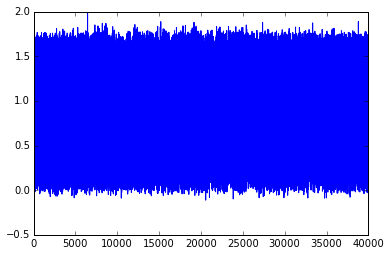

In [10]:
trace, accepted = metropolis(50000,0,"u")
print(np.exp(trace[-1])/(1+np.exp(trace[-1])))
plt.plot(trace[10000:])
print("Num accepted is " + str(accepted))

We see that even with half the iterations, we get a value similar to the original value.

## Your final conclusion does not make sense. It is not close to the original value

## 21/25

Problem 2: 

In [18]:
%matplotlib inline
import pymc as pm
from pymc import Normal, Binomial, invlogit, Lambda, MCMC
from scipy.stats.distributions import binom
from pymc import MCMC, Matplot, Metropolis

In [19]:
#Data
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

We assume the true baseline mean (on a log-odds scale) $\mu_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\end{aligned}$$

We look at 4 different cases that can be used while modelling this specific model. The choice depends on whether we have random or fixed effects for population mean and treatment effect. 

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\mu_{\text{new}}$ in a new trial. 

So, the prior we place on $\mu_i$:

$$\begin{aligned}
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

Also, since we are considering a random effect, we assume that:

$$\begin{aligned}
m &\sim \text{Normal}(0, \sigma)\\
s &\sim \text{Normal}(0, \sigma)
\end{aligned}$$

where the choice of $\sigma$ is such that the distribution is vague and uninformative.

Here, we assume a fixed effect for the treatment effect.


In [20]:
'''
Case 1 : Consider random effect for mu and fixed effect for delta
'''

import pylab as pl
import pymc as mc
import numpy as np

def meta_analysis():
    ###priors on d and tau
    d = 0 
    tau = 0.00001

    ###priors on m and s
    m = mc.Normal('m', 0, 0.00001, value = 0)
    s = mc.Normal('s',0, 0.00001, value = 1)

    #sigma = mc.Lambda('sigma', lambda tau=tau: tau**-.5)
    #delta_new = mc.Normal('delta_new', d, tau, value=0.)


    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    return locals()



## You do not need to use a list comprehension for the random effect; just give mu an array value

In [21]:
M = MCMC(meta_analysis())
M.sample(10000,burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 23.8 sec

Plotting m


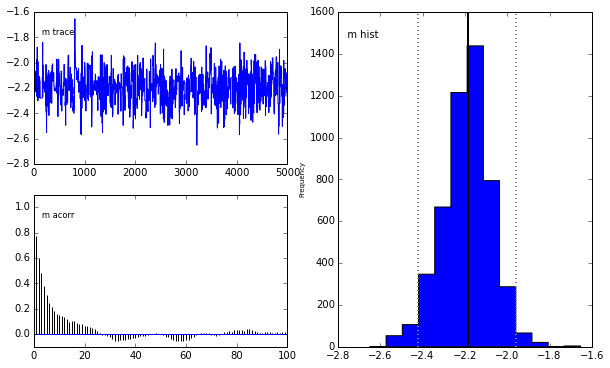

In [22]:
%matplotlib inline
Matplot.plot(M.m)

Plotting s


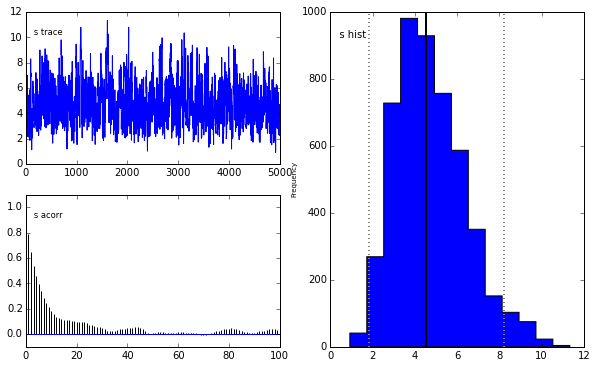

In [23]:
%matplotlib inline
Matplot.plot(M.s)

We observe from the traces that both the parameters explore the input space well and the autocorrelation goes down as we look at draws further behind. 

In [24]:
'''
Plot geweke_plot to see convergence
'''
from pymc import geweke
d = geweke(M.m,intervals=20)


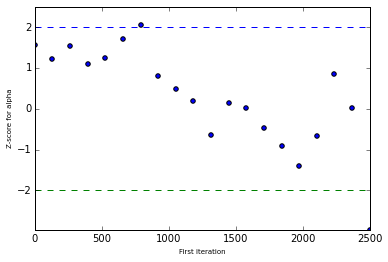

In [25]:
'''
Plot the geweke plot
'''
Matplot.geweke_plot(d,'alpha')

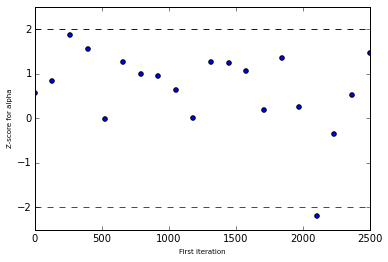

In [26]:
d = geweke(M.s,intervals=20)
Matplot.geweke_plot(d,'alpha')

We see from the geweke plots that most of the scores lie within the two standard deviation boundaries around 0.

In [27]:
from pymc import gelman_rubin

M = MCMC(meta_analysis())
M.sample(2000)
M.sample(2000)
M.sample(2000)
gelman_rubin(M)

 [-----------------100%-----------------] 2000 of 2000 complete in 4.8 sec

{'delta': 1.0203810346326092,
 'm': 1.0043575386433061,
 'mu_0': 1.0000726944003917,
 'mu_1': 0.99974378195911118,
 'mu_10': 1.0044069671900966,
 'mu_11': 1.0022942268536617,
 'mu_12': 1.00907254978071,
 'mu_13': 1.0004947320715631,
 'mu_14': 1.0090954637827583,
 'mu_15': 1.024013067634951,
 'mu_16': 1.0006487330116438,
 'mu_17': 0.99990225689908074,
 'mu_18': 1.0003253555650642,
 'mu_19': 1.0192495700503701,
 'mu_2': 1.0035454207253973,
 'mu_20': 1.0108584241489293,
 'mu_21': 1.0045975284592346,
 'mu_3': 1.0296892090167291,
 'mu_4': 1.0009381241466835,
 'mu_5': 0.99978455357016016,
 'mu_6': 1.0049680577278313,
 'mu_7': 1.0039045709884957,
 'mu_8': 1.0209726655498594,
 'mu_9': 1.0219207438380458,
 'p_c': [1.0002618568933168,
  0.99965465035957457,
  1.0029386367312845,
  1.0159394141716818,
  1.0022489308140932,
  0.99967292792618401,
  1.0051434023857648,
  1.0044145919201213,
  1.017872288459104,
  1.0195415333710185,
  1.0049054506168327,
  1.0021100721903364,
  1.0106816184524723,


We work with the Gelman-Rubin convergence diagonistic, which looks at both the within chain variance and between chain variances. We find that all values are very close to 1.

In [28]:
'''
Do Goodness of fit test
'''

def meta_analysis_gof():
    ###fixed m and s
    m = 0 
    s = 0.00001

    ###priors on d and t
    d = mc.Normal('d', 0, 0.0000001, value = 0)
    #tau = mc.Gamma('t',0.001, 0.001, value = 1)
    tau = mc.Normal('t',0, 0.00001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    r_c_Simulated = mc.Binomial('r_c', n_c_obs, p_c)
    r_t_Simulated = mc.Binomial('r_t', n_t_obs, p_t)
    
    return locals()


In [29]:
M_gof = MCMC(meta_analysis_gof())
M_gof.sample(10000,burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 28.7 sec

/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


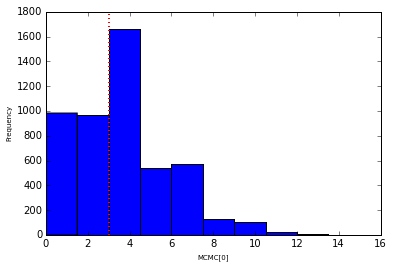

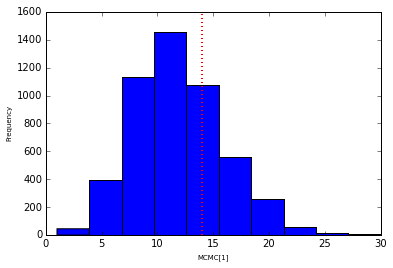

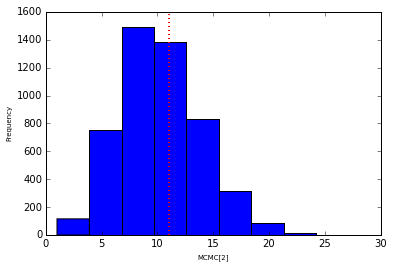

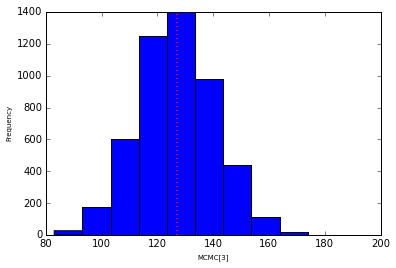

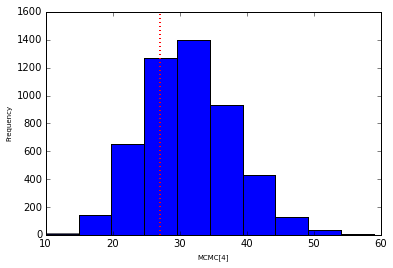

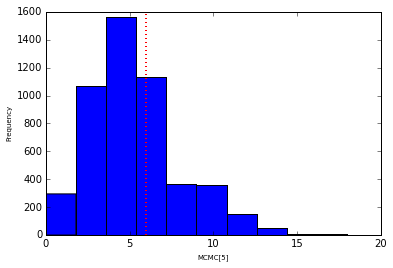

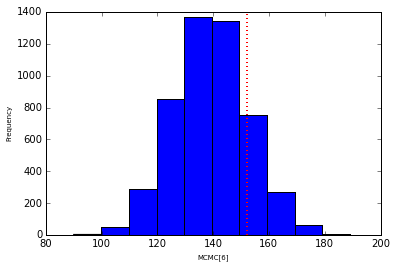

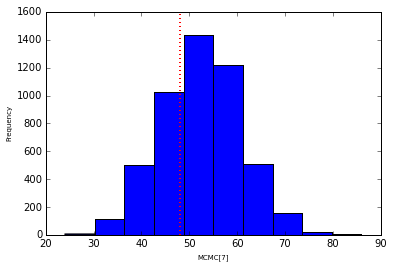

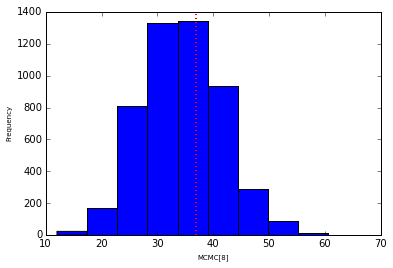

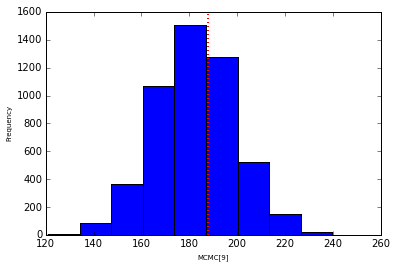

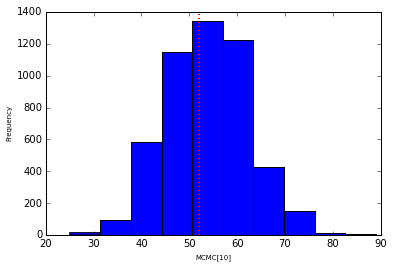

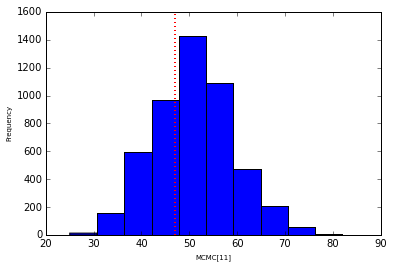

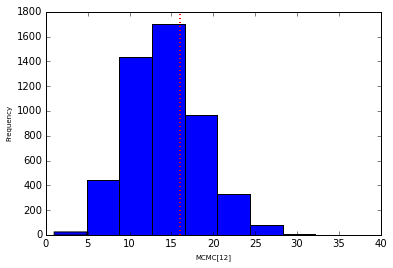

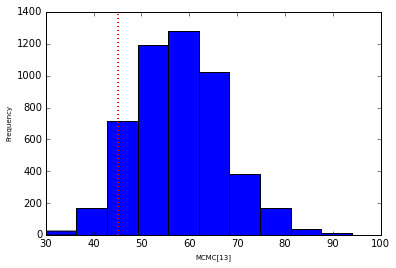

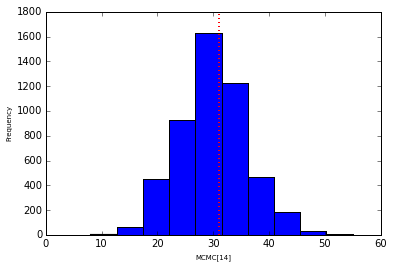

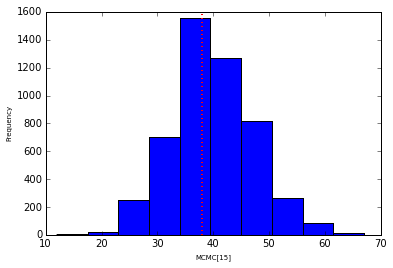

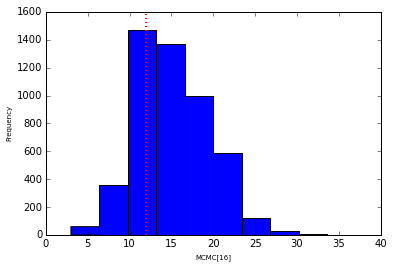

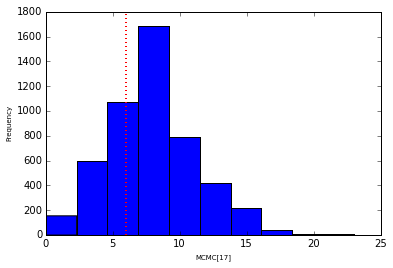

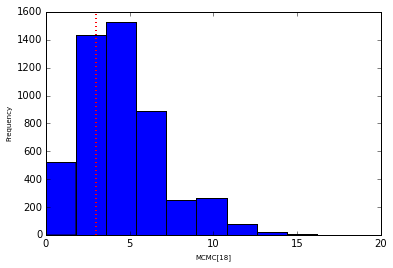

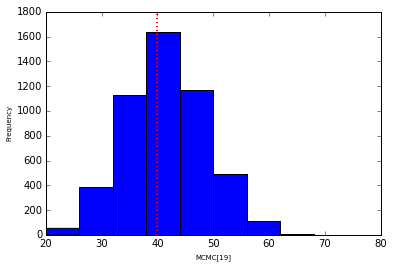

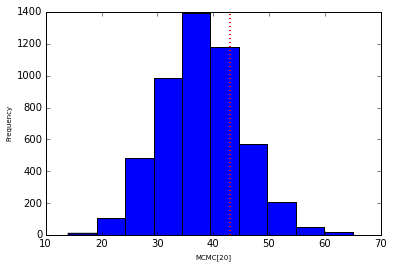

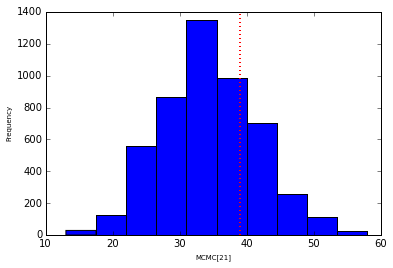

In [30]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_c_Simulated.trace(), r_c_obs, bins=10)

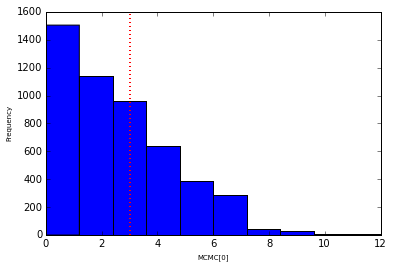

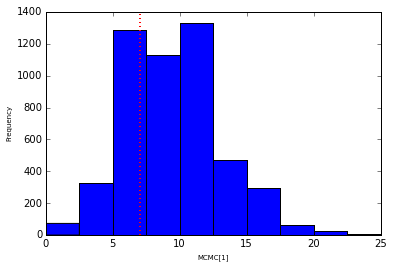

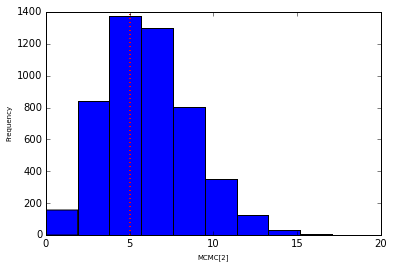

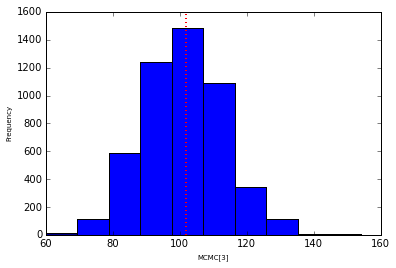

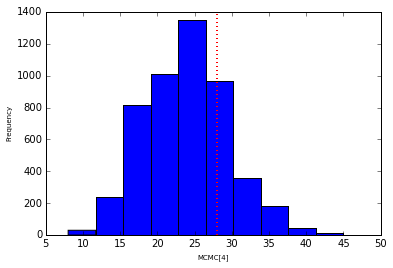

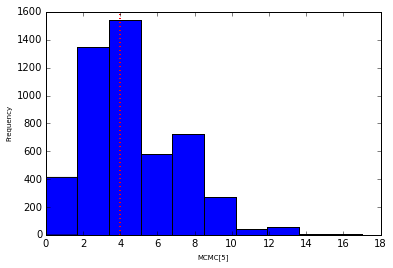

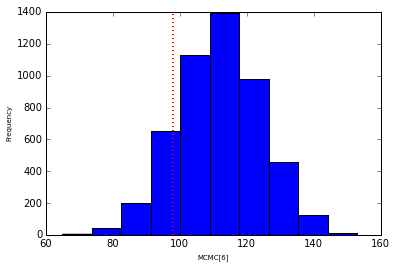

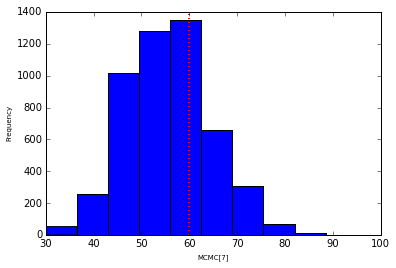

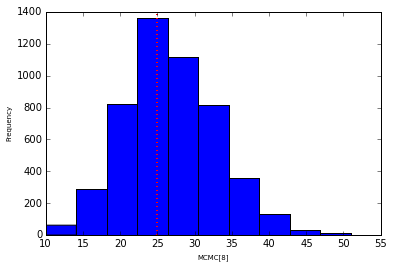

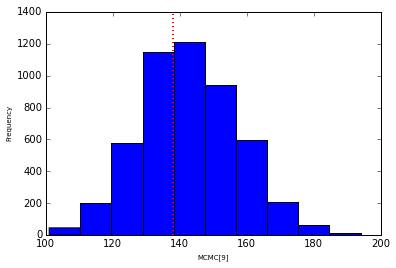

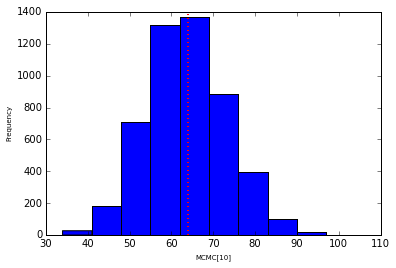

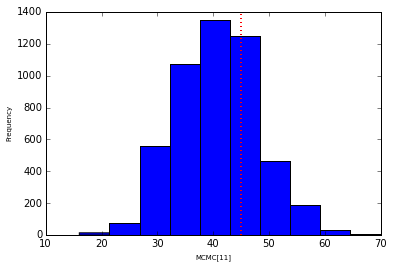

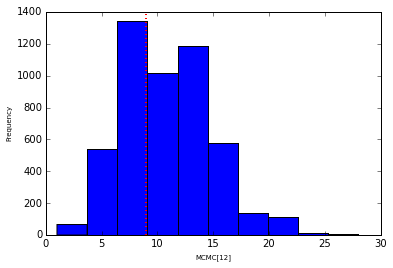

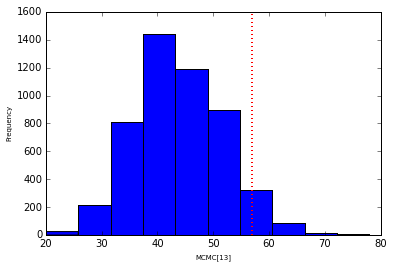

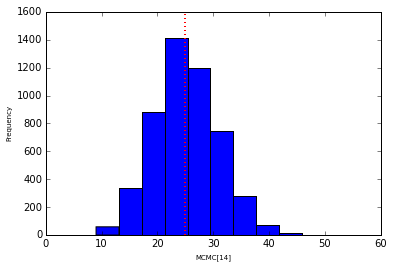

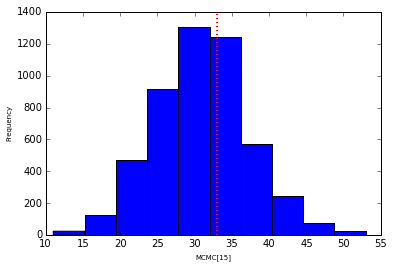

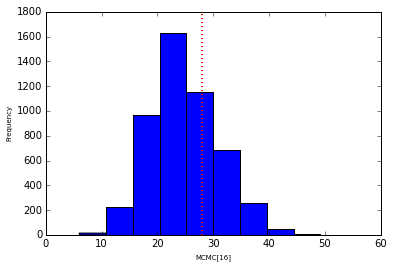

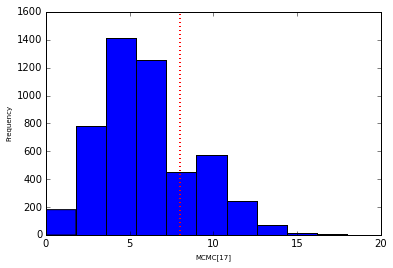

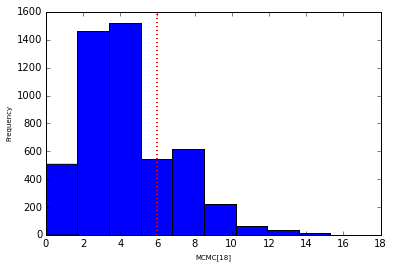

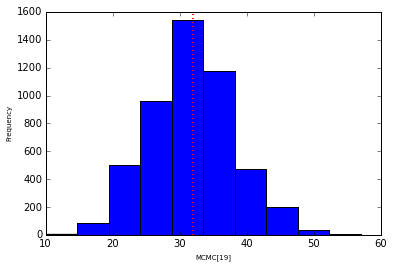

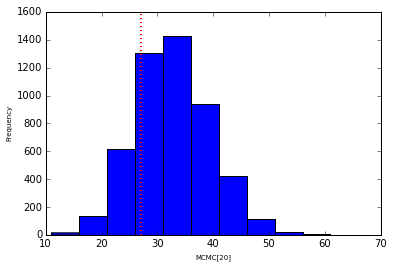

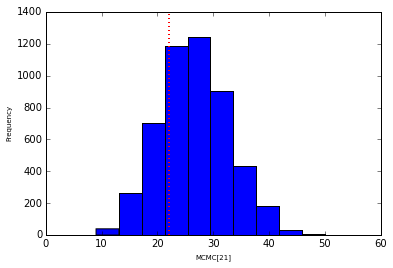

In [31]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_t_Simulated.trace(), r_t_obs, bins=10)

For doing a goodness of fit test, we simualate values from our fitted model and see if they are similar to the original observed data or not. This is done as a model that has converged might not be the correct model. We find that most of the simulated data is close to the original data. The discrepancies can be attributed to the fact that we are trying to fit our model with very limited data.

In [32]:
'''
Get the DIC Value
'''
M.DIC

287.04975532985918

Lastly, we find the DIC value that will be used later to find the most suitable model.

The next case assumes a fixed effect for the population effect but a random effect for the treatment effect. Here, we assume that $m$ and $s$ are fixed but we define distributions over $d$ and $\tau$. So we assume that

$$\begin{align}
d &\sim \text{Normal}(0, \sigma) \\
\tau &\sim \text{Normal}(0, \sigma)
\end{align}$$

where again, $\sigma$ is chosen such that the precision is very low. Here, we keep $m$ and $s$ fixed. I also tried putting a $gamma$ distribution over $\tau$ but the results were similar.

In [33]:
'''
Case 2 : Consider random effect for delta and fixed effect for mu
'''
import pylab as pl
import pymc as mc
import numpy as np

def meta_analysis():
    ###fixed m and s
    m = 0 
    s = 0.00001

    ###priors on d and t
    d = mc.Normal('d', 0, 0.0000001, value = 0)
    #tau = mc.Gamma('t',0.001, 0.001, value = 1)
    tau = mc.Normal('t',0, 0.00001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    return locals()


## There is no random effect for delta above

In [34]:
M = MCMC(meta_analysis())
M.sample(100000,burn=5000)

 [-----------------100%-----------------] 100000 of 100000 complete in 223.0 sec

Plotting d


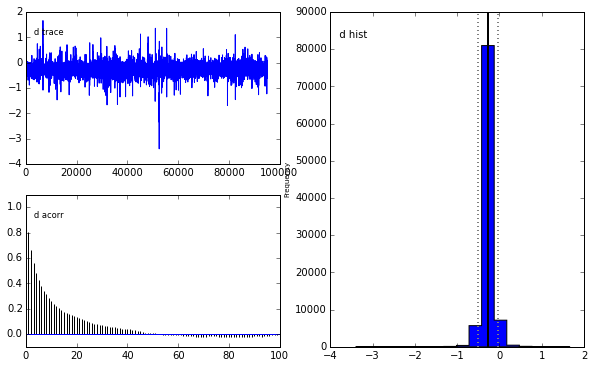

In [35]:
%matplotlib inline
Matplot.plot(M.d)

Plotting t


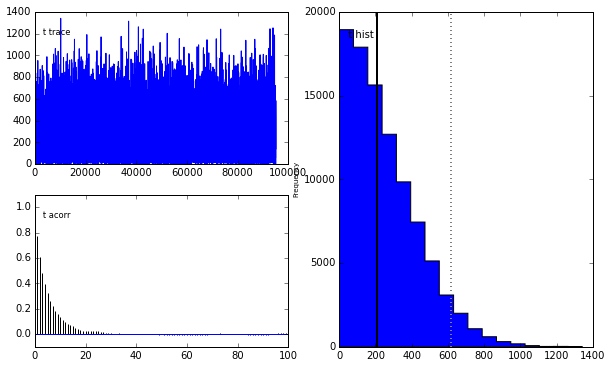

In [36]:
%matplotlib inline
Matplot.plot(M.tau)

We see that the MCMC chain explores the space of the parameters well and the autocorrelation decreases as we look further back.

In [37]:
d = geweke(M.d,intervals=20)

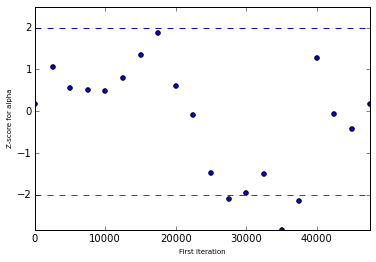

In [38]:
'''
Plot the geweke plot
'''
Matplot.geweke_plot(d,'alpha')

In [39]:
d = geweke(M.tau,intervals=20)

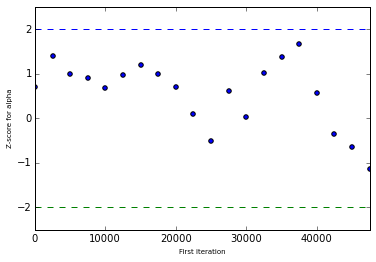

In [40]:
'''
Plot the geweke plot
'''
Matplot.geweke_plot(d,'alpha')

We find that all the geweke z-scores are between the two standard deviation lines around 0.

In [41]:
from pymc import gelman_rubin

M = MCMC(meta_analysis())
M.sample(2000)
M.sample(2000)
M.sample(2000)
gelman_rubin(M)

 [-----------------100%-----------------] 2000 of 2000 complete in 4.4 sec

{'d': 1.0027924460953139,
 'delta': 1.0234180885209259,
 'mu_0': 1.0154075197842254,
 'mu_1': 0.99977117823786665,
 'mu_10': 1.000605640819362,
 'mu_11': 1.0181077829783765,
 'mu_12': 1.0001849774991076,
 'mu_13': 1.0228994515163174,
 'mu_14': 1.002994428413202,
 'mu_15': 1.00485069385182,
 'mu_16': 1.0204257118309681,
 'mu_17': 1.0052833566242563,
 'mu_18': 1.0063026695346149,
 'mu_19': 1.0038257554123504,
 'mu_2': 1.0096643605058007,
 'mu_20': 0.99997038316698306,
 'mu_21': 1.0013924369384646,
 'mu_3': 1.0381304775062536,
 'mu_4': 1.0165267736741934,
 'mu_5': 1.0004401256899125,
 'mu_6': 1.0037631607463393,
 'mu_7': 1.0008729390594828,
 'mu_8': 1.0035946278134809,
 'mu_9': 1.01036281535608,
 'p_c': [1.0140122924596533,
  0.99974620422865002,
  1.0118711434886711,
  1.0368982878550426,
  1.0123201915859674,
  1.0010802997977142,
  1.0039288054824256,
  1.0014836796603894,
  1.0042264676314332,
  1.0086313490999332,
  0.99968345604203379,
  1.0173849260155228,
  1.0022440049100325,
  1

We do the Gelman-Rubin diagnostic to check the convergence of chains. Here we are assuming that if multiple chains have converged, then they must be very similar to one another. We see that most of the scores are very close to 1.

In [42]:
'''
Do goodness of fit test
'''
def meta_analysis_gof():
    
    ###fixed m and s
    m = 0 
    s = 0.00001

    ###priors on d and t
    d = mc.Normal('d', 0, 0.0000001, value = 0)
    #tau = mc.Gamma('t',0.001, 0.001, value = 1)
    tau = mc.Normal('t',0, 0.00001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)

    
    r_c_Simulated = mc.Binomial('r_c', n_c_obs, p_c)
    r_t_Simulated = mc.Binomial('r_t', n_t_obs, p_t)
    
    return locals()


In [43]:
M_gof = MCMC(meta_analysis_gof())
M_gof.sample(10000,burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 28.7 sec

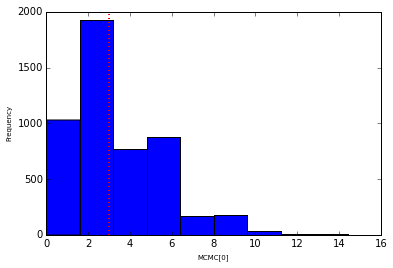

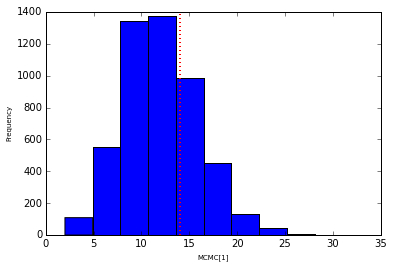

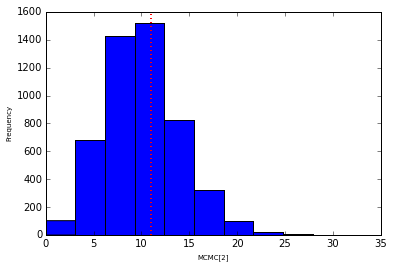

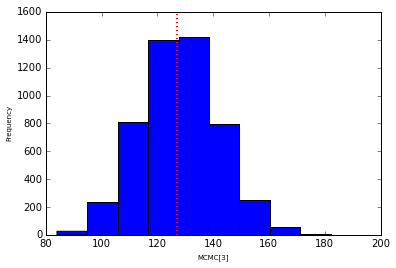

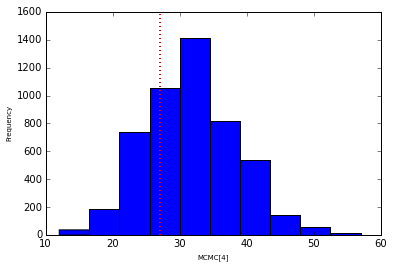

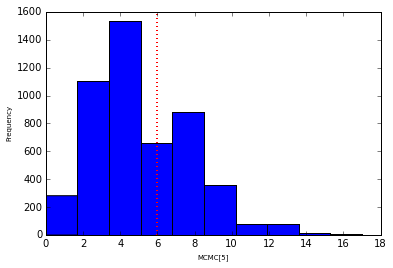

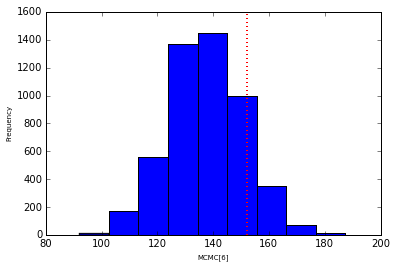

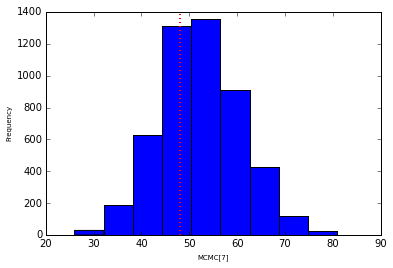

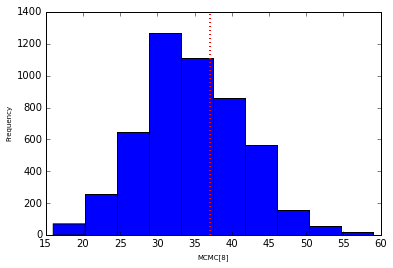

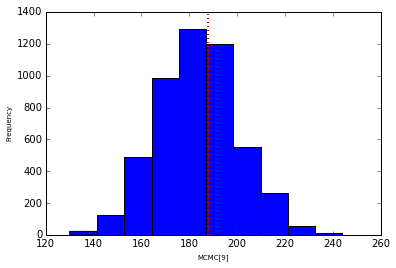

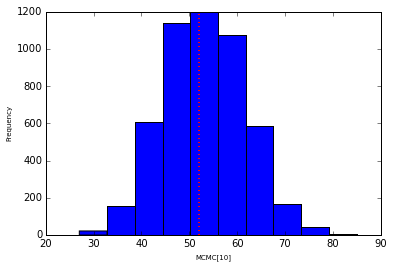

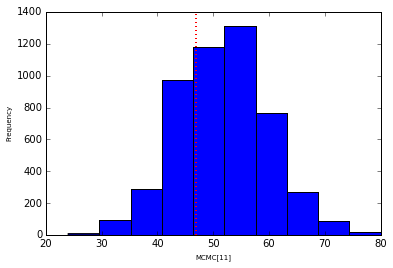

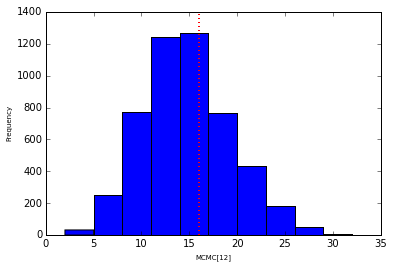

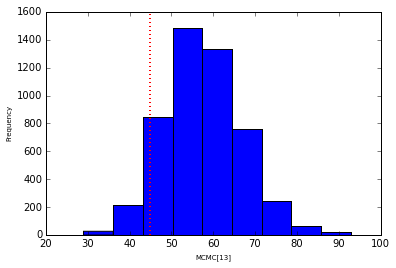

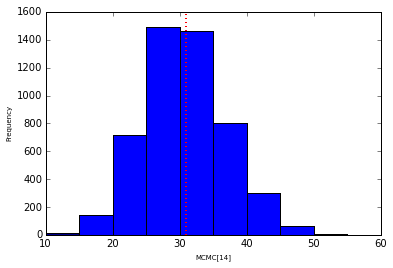

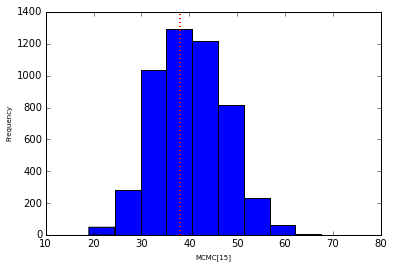

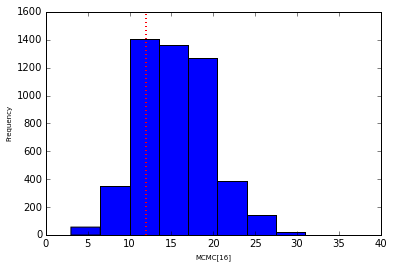

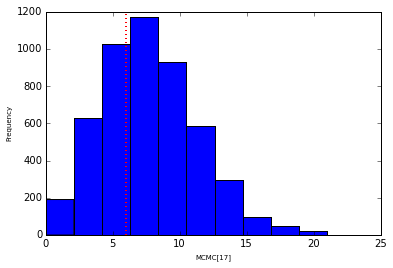

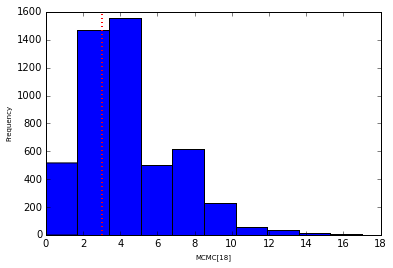

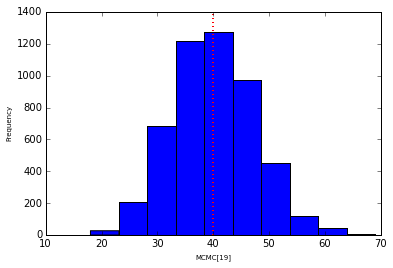

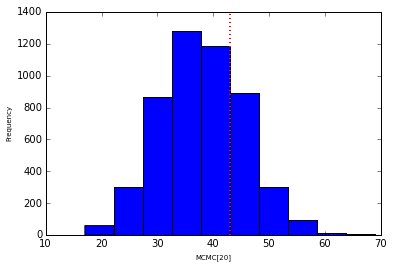

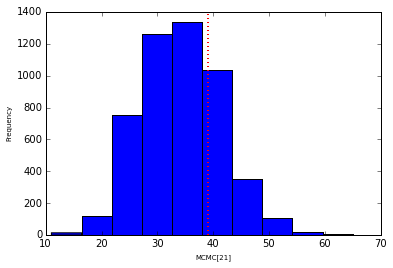

In [44]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_c_Simulated.trace(), r_c_obs, bins=10)

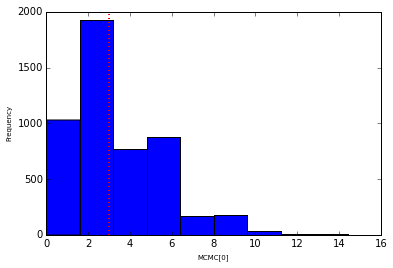

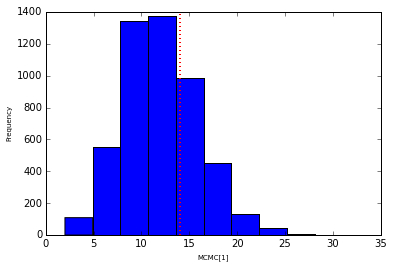

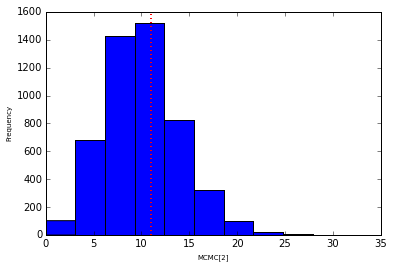

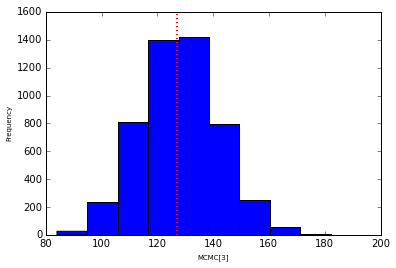

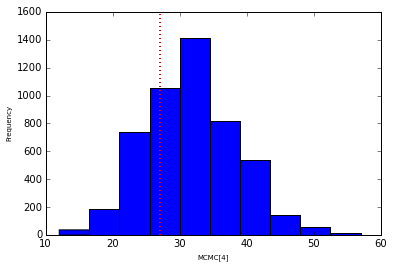

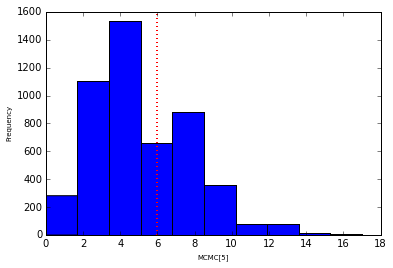

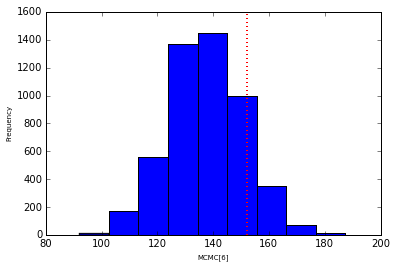

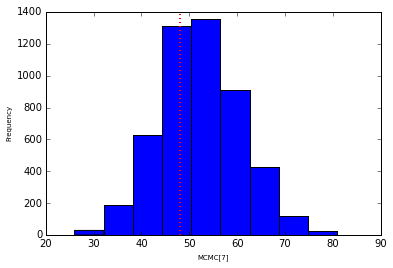

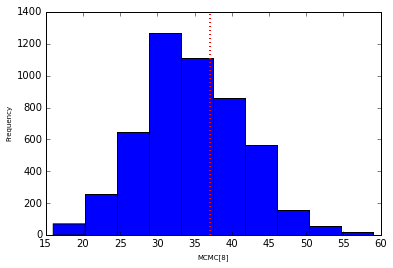

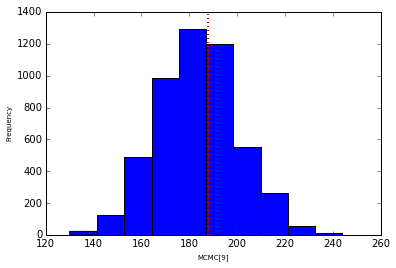

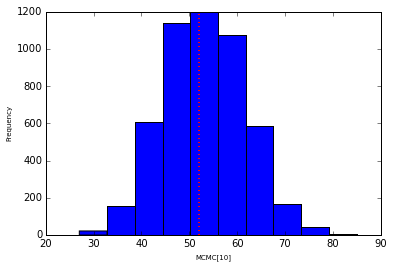

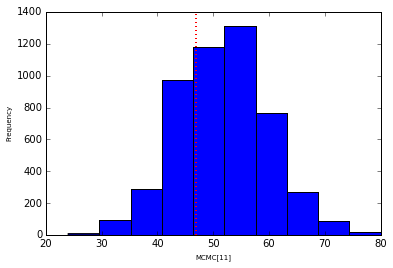

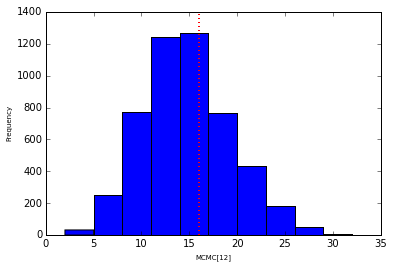

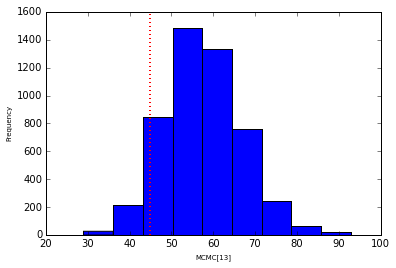

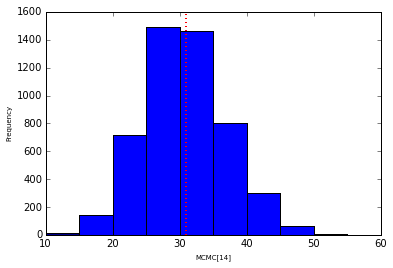

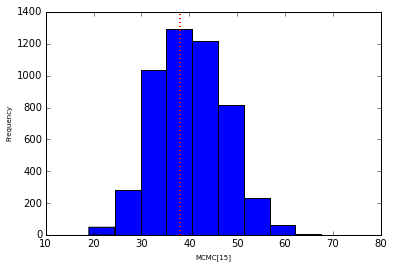

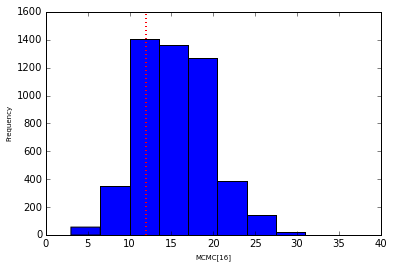

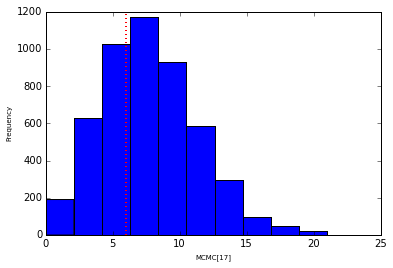

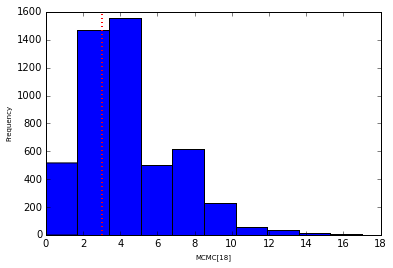

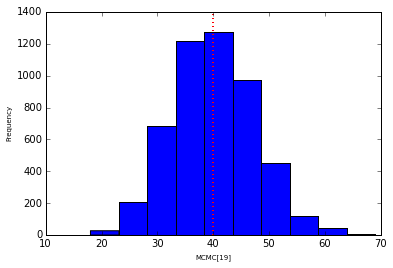

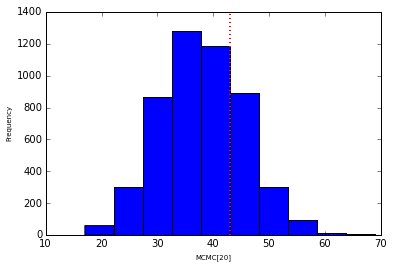

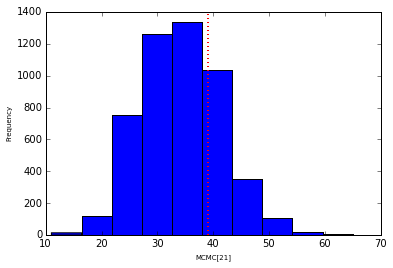

In [45]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_c_Simulated.trace(), r_c_obs, bins=10)

In order to check the goodness of fit, we simulate data from the function that we fit and compare it with the actual data. We see that most of the simulated data is very close to the observed data.

In [46]:
M.DIC

285.42660282290353

We note the DIC score to compare models later.

In the third case, we assume that both the population effect and the treatment effect have fixed effects on our model. Hence we assume that $m$, $s$, $d$ and $\tau$ are all fixed.

In [47]:
'''
Case 3 : Consider fixed effects for both mu and delta
'''

import pylab as pl
import pymc as mc
import numpy as np

def meta_analysis():
    ###priors on d and tau
    m = 0 
    s = 0.00001

    ###priors on d and t
    d = 0
    tau = 0.00001 

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    return locals()

## This appears to be the same model as the previous one, essentially

In [48]:
M = MCMC(meta_analysis())
M.sample(100000,burn=5000)

 [-----------------100%-----------------] 100000 of 100000 complete in 214.5 sec

Here we are not interested in $m$, $s$, $d$ and $\tau$ as they are fixed. We look at whether the chains have converged or not by looking at the gelman_rubin method. 

In [49]:
M = MCMC(meta_analysis())
M.sample(2000)
M.sample(2000)
M.sample(2000)
gelman_rubin(M)


 [-----------------100%-----------------] 2000 of 2000 complete in 4.3 sec

{'delta': 1.0414543694438185,
 'mu_0': 1.0091341574240158,
 'mu_1': 1.0064408738415818,
 'mu_10': 1.0303924857629863,
 'mu_11': 1.0164347951223176,
 'mu_12': 1.0001652577028488,
 'mu_13': 1.0020916317955078,
 'mu_14': 1.0019221480585494,
 'mu_15': 1.0036611809700653,
 'mu_16': 1.0084440878573095,
 'mu_17': 1.0017677684986781,
 'mu_18': 1.0073596740544892,
 'mu_19': 1.0257746288664642,
 'mu_2': 0.99964077142255769,
 'mu_20': 1.0005544698455442,
 'mu_21': 1.0127571181460611,
 'mu_3': 1.021268306351315,
 'mu_4': 1.0007614904481792,
 'mu_5': 0.99961917132728229,
 'mu_6': 1.0113189635176401,
 'mu_7': 1.0232485151690782,
 'mu_8': 1.0307912848833676,
 'mu_9': 1.0084234737468762,
 'p_c': [1.0089126406788311,
  1.0062904660108256,
  0.99987738350383615,
  1.0129571258775212,
  1.0025264275557197,
  0.99989957945036367,
  1.0125459084332464,
  1.020709725861108,
  1.0268604395740444,
  1.0076503329650093,
  1.0252609652625162,
  1.0166956108695568,
  1.0009978169785669,
  1.0013953002221923,
  1

We do a goodness of fit evaluation by goinf through the same process as before. We simulate data and then compare it with our original data.

In [50]:
'''
Do goodness of fit test
'''
def meta_analysis_gof():
    
    ###priors on d and tau
    m = 0 
    s = 0.00001

    ###priors on d and t
    d = 0
    tau = 0.00001 

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
   
    r_c_Simulated = mc.Binomial('r_c', n_c_obs, p_c)
    r_t_Simulated = mc.Binomial('r_t', n_t_obs, p_t)
    
    return locals()

In [51]:
M_gof = MCMC(meta_analysis_gof())
M_gof.sample(10000,burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 28.3 sec

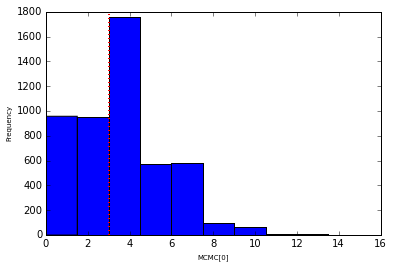

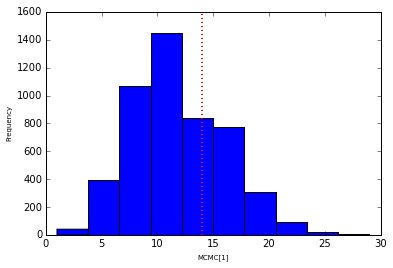

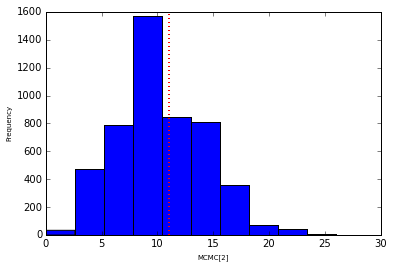

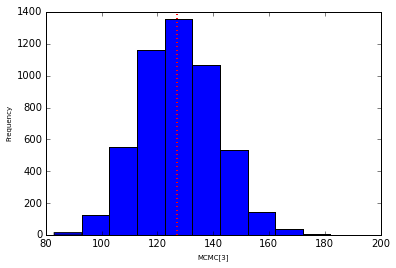

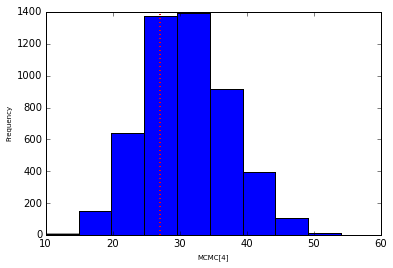

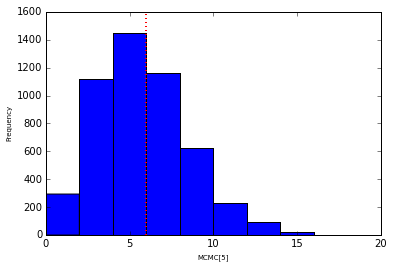

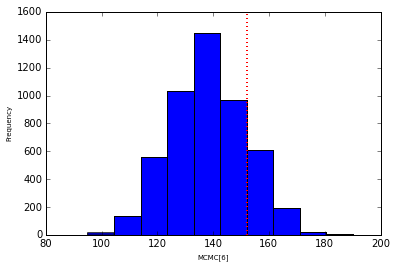

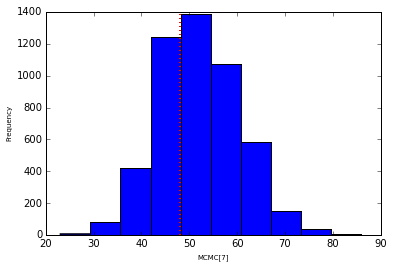

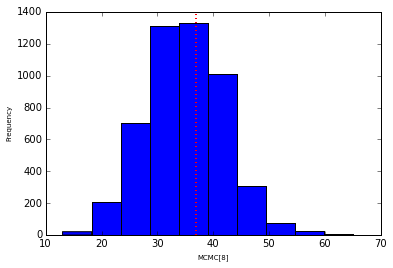

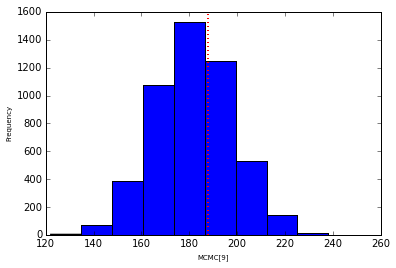

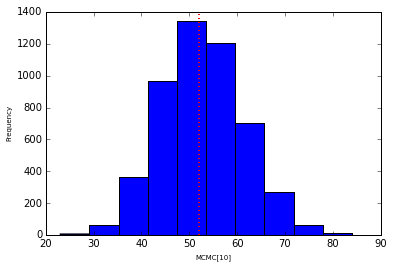

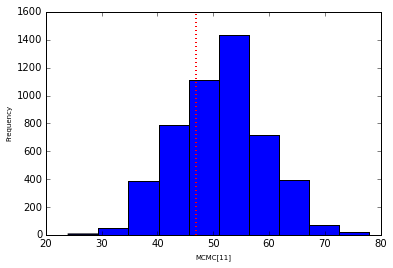

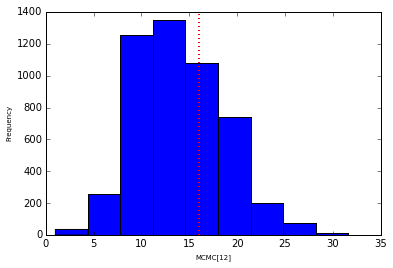

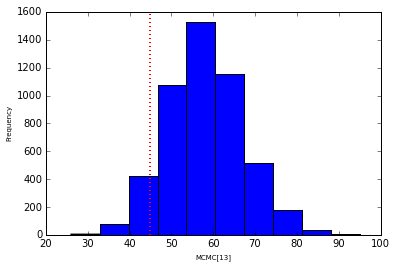

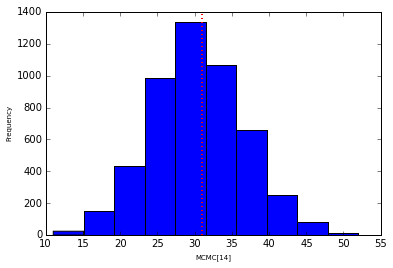

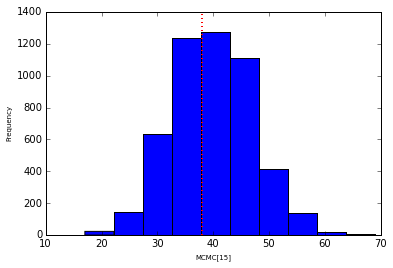

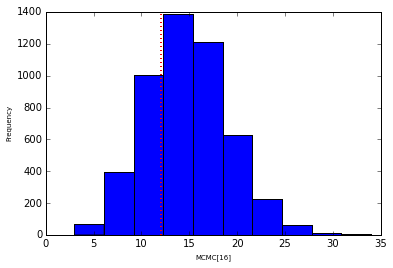

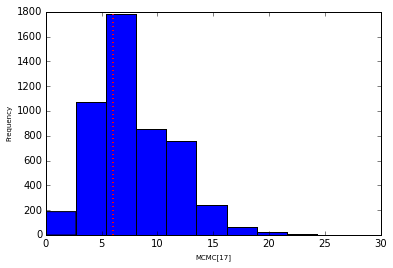

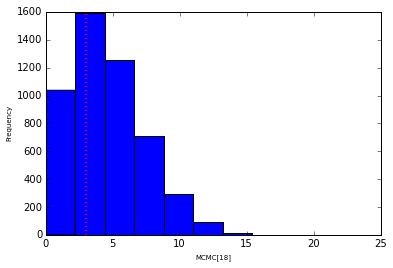

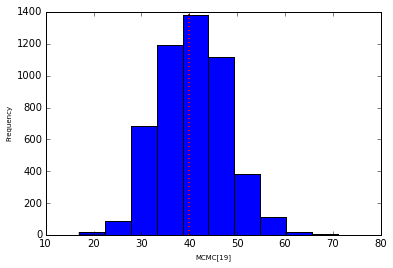

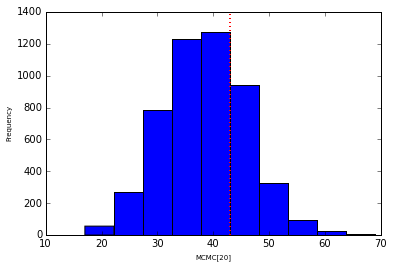

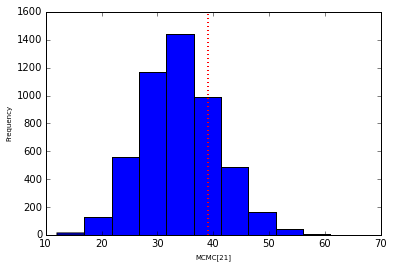

In [52]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_c_Simulated.trace(), r_c_obs, bins=10)

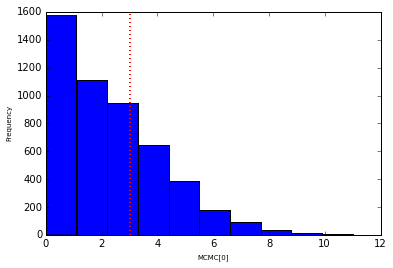

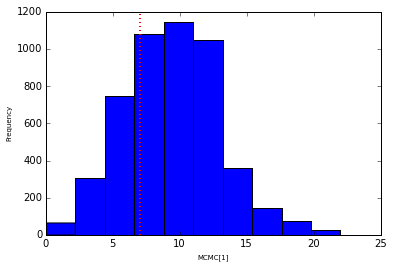

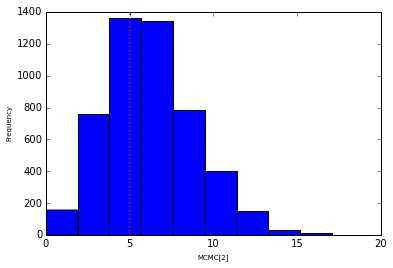

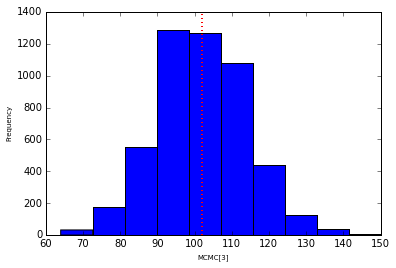

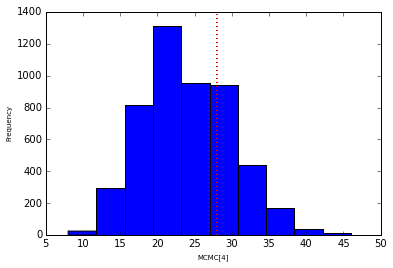

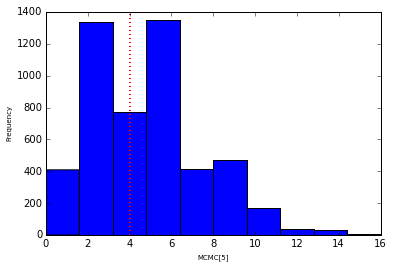

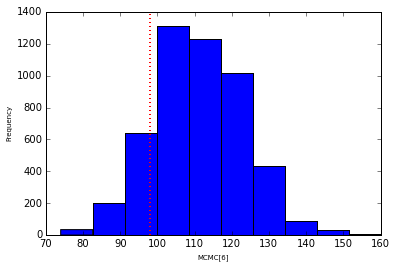

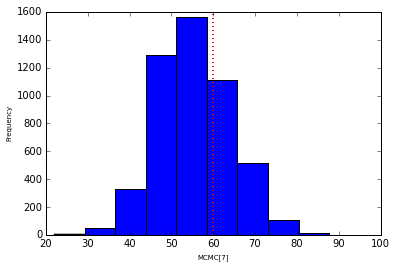

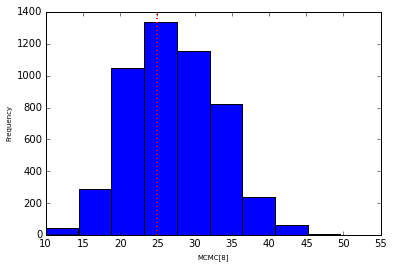

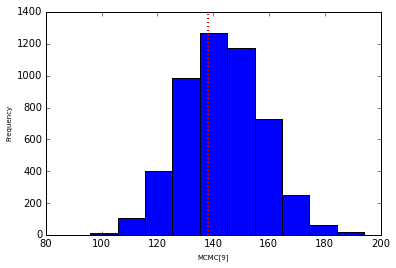

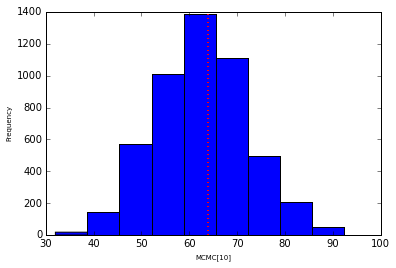

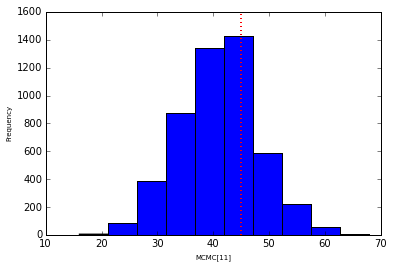

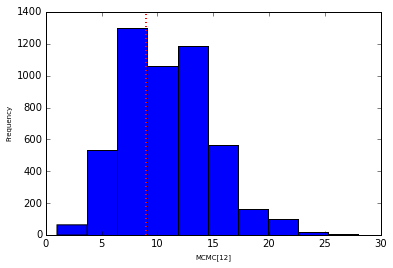

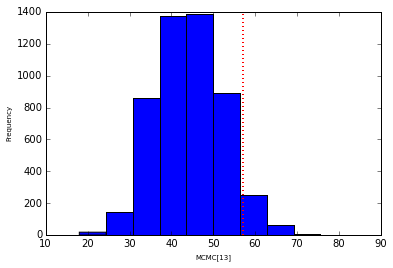

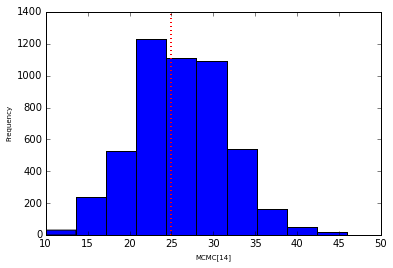

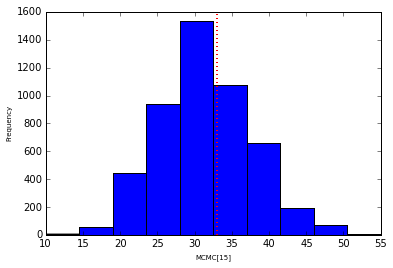

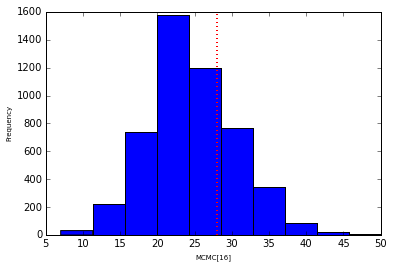

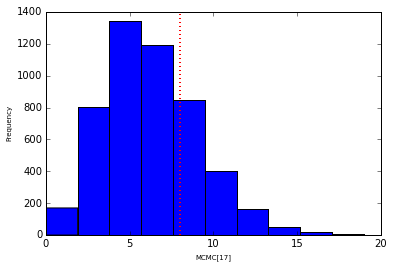

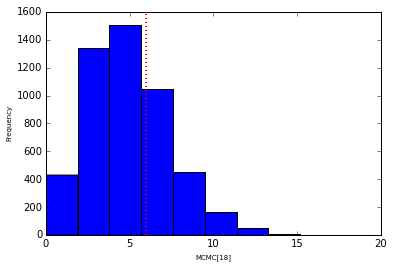

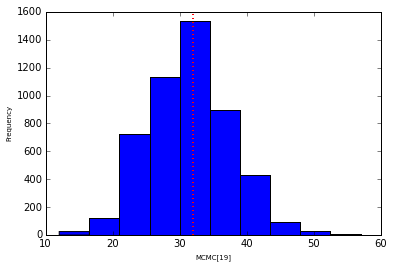

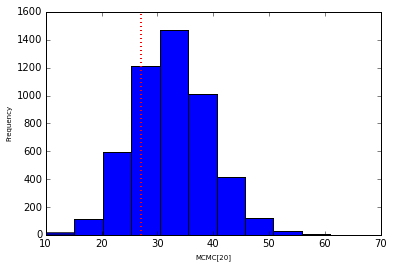

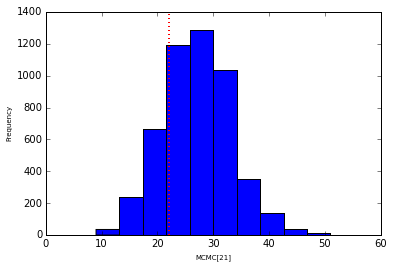

In [53]:
#Check goodness of fit with respect to r_t
Matplot.gof_plot(M_gof.r_t_Simulated.trace(), r_t_obs, bins=10)

Although we observe some variations, the simulateda data is very close to the original data.

We keep a look at the DIC score to use later.

In [54]:
M.DIC

287.66568007959302

Finally we consider the case where both treatment and population effects have a random effect on our model. The distributions that we put are:

$$\begin{align}
m &\sim \text{Normal}(0, \sigma) \\
s &\sim \text{Normal}(0, \sigma) \\
d &\sim \text{Normal}(0, \sigma) \\
\tau &\sim \text{Normal}(0, \sigma)
\end{align}$$



The priors on means and the treatment effect stay the same as before

In [55]:
'''
Case 4 : Consider random effects for both
'''

import pylab as pl
import pymc as mc
import numpy as np

def meta_analysis():
    ###priors on d and tau
    m = mc.Normal('m', 0, 0.00001, value = 0)
    s = mc.Normal('s',0, 0.00001, value = 1)

    ###priors on d and t
    d = mc.Normal('d', 0, 0.00001, value = 0)
    tau = mc.Normal('t',0, 0.00001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    return locals()

In [56]:
M = MCMC(meta_analysis())
M.sample(100000,burn=5000)

 [-----------------100%-----------------] 100000 of 100000 complete in 251.8 sec

Plotting d


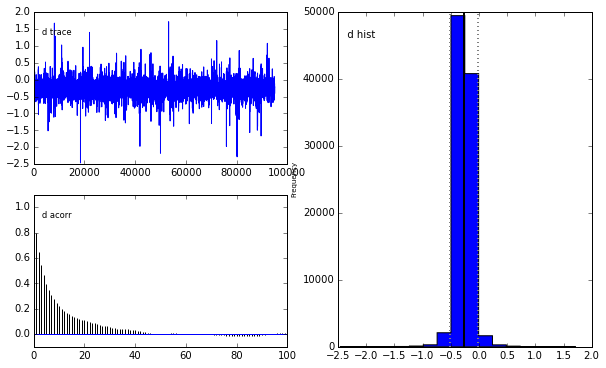

In [57]:
%matplotlib inline
Matplot.plot(M.d)

Plotting t


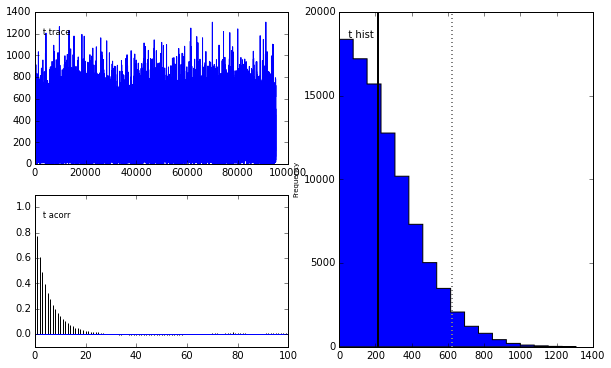

In [58]:
%matplotlib inline
Matplot.plot(M.tau)

Plotting m


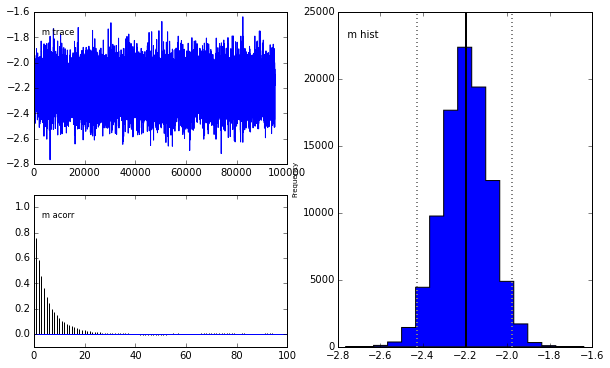

In [59]:
%matplotlib inline
Matplot.plot(M.m)

Plotting s


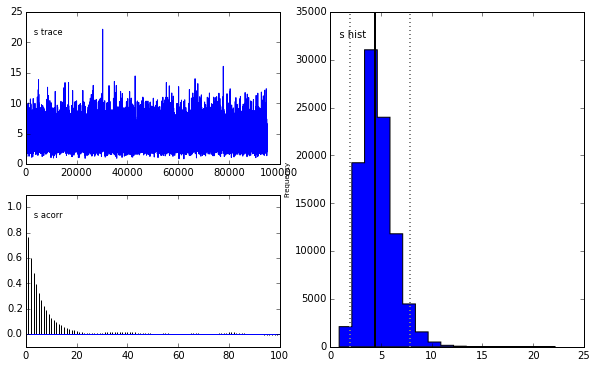

In [60]:
%matplotlib inline
Matplot.plot(M.s)

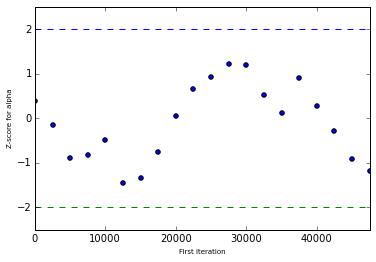

In [61]:
d = geweke(M.m,intervals=20)
Matplot.geweke_plot(d,'alpha')

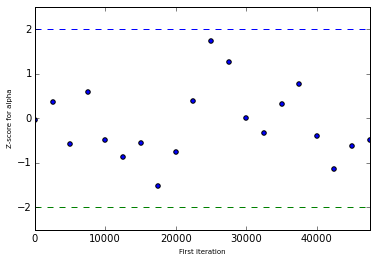

In [62]:
d = geweke(M.s,intervals=20)
Matplot.geweke_plot(d,'alpha')

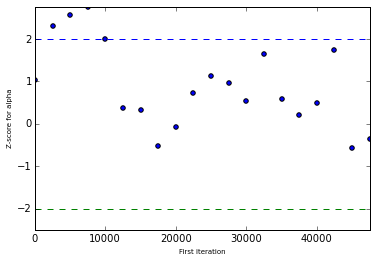

In [63]:
d = geweke(M.d,intervals=20)
Matplot.geweke_plot(d,'alpha')

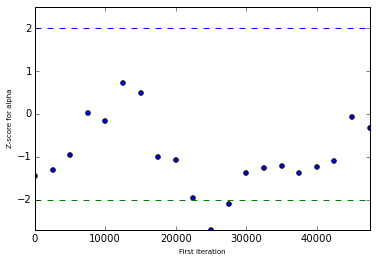

In [64]:
d = geweke(M.tau,intervals=20)
Matplot.geweke_plot(d,'alpha')

We observe that the MCMC procedure explores the input space well. However, there are some deviations from the standard-normal assumption when we look at the geweke z-scores.

In [65]:
M = MCMC(meta_analysis())
M.sample(2000)
M.sample(2000)
M.sample(2000)
gelman_rubin(M)

 [-----------------100%-----------------] 2000 of 2000 complete in 5.0 sec

{'d': 1.0096592486913898,
 'delta': 1.0726591879491507,
 'm': 1.0375572435304177,
 'mu_0': 1.0151636367090817,
 'mu_1': 1.0065971440177535,
 'mu_10': 1.0473179388433871,
 'mu_11': 1.013874971114358,
 'mu_12': 1.0056892106048021,
 'mu_13': 1.0182201658520231,
 'mu_14': 1.0194798763619497,
 'mu_15': 1.012953303984117,
 'mu_16': 1.0211321029947571,
 'mu_17': 1.0013817430630572,
 'mu_18': 1.0137301981938904,
 'mu_19': 1.0008586155255932,
 'mu_2': 1.0090218050203563,
 'mu_20': 1.0176567849735667,
 'mu_21': 1.0215632680274638,
 'mu_3': 1.016002441023506,
 'mu_4': 1.0095059310467298,
 'mu_5': 1.0069338717232952,
 'mu_6': 1.0206160480181004,
 'mu_7': 1.0488811203629445,
 'mu_8': 1.0083636399533333,
 'mu_9': 1.0411734281735423,
 'p_c': [1.0162488636417888,
  1.0078895872552933,
  1.0094546632932349,
  1.0117803224070405,
  1.010590511811041,
  1.009021871752884,
  1.0208789071025861,
  1.0456442315054948,
  1.0087482643359347,
  1.0281380204771686,
  1.0362904854649342,
  1.0134976614043165,
  

We see that $\tau$ is significantly away from 1 when we use the Gelman-Rubin method.

In [83]:
M.DIC

284.8713362314586

In [66]:
'''
Case 4 : Consider random effects for both
'''

import pylab as pl
import pymc as mc
import numpy as np

def meta_analysis():
    ###priors on d and tau
    m = mc.Normal('m', 0, 0.00001, value = 0)
    s = mc.Normal('s',0, 0.00001, value = 1)

    ###priors on d and t
    d = mc.Normal('d', 0, 0.00001, value = 0)
    tau = mc.Gamma('t',0.0001, 0.0001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    return locals()

We try putting a gamma prior that is more flexible.

In [67]:
M = MCMC(meta_analysis())
M.sample(100000,burn=5000)

 [-----------------100%-----------------] 100000 of 100000 complete in 249.5 sec

Plotting m


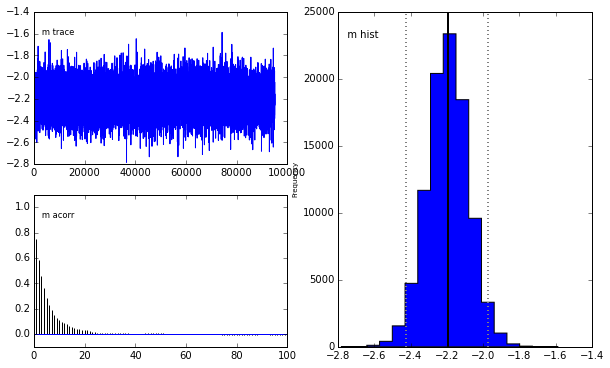

In [68]:
Matplot.plot(M.m)

Plotting s


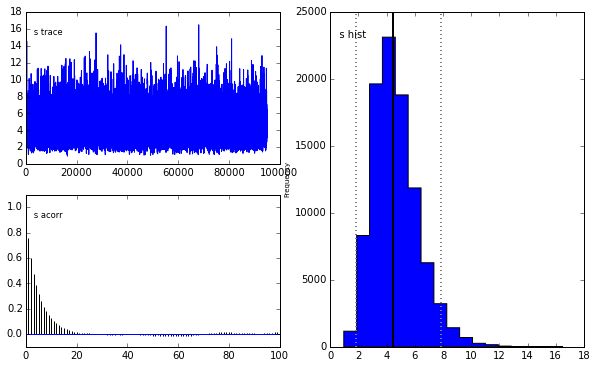

In [69]:
Matplot.plot(M.s)

Plotting d


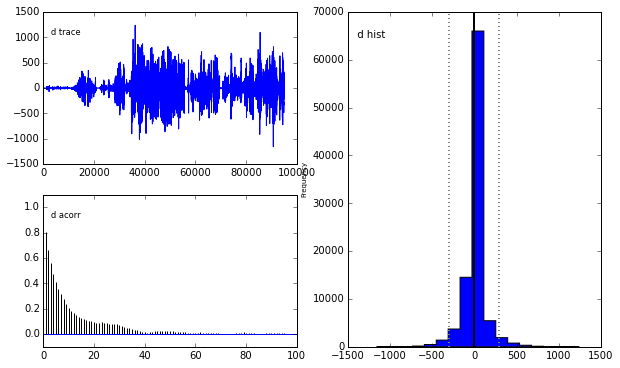

In [70]:
Matplot.plot(M.d)

## Lack of convergence

Plotting t


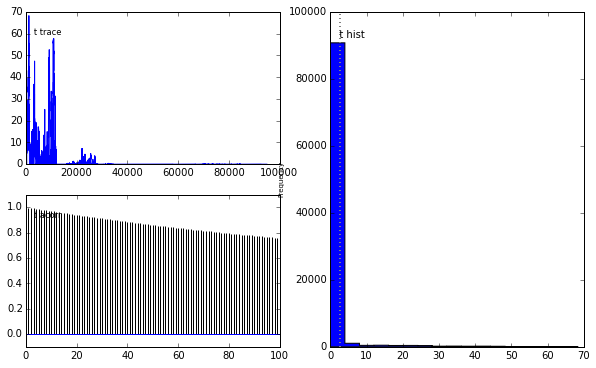

In [72]:
Matplot.plot(M.tau)

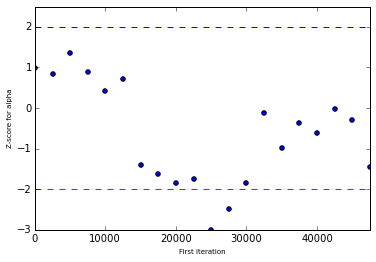

In [73]:
d = geweke(M.m,intervals=20)
Matplot.geweke_plot(d,'alpha')

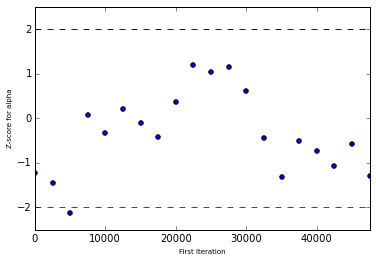

In [74]:
d = geweke(M.s,intervals=20)
Matplot.geweke_plot(d,'alpha')

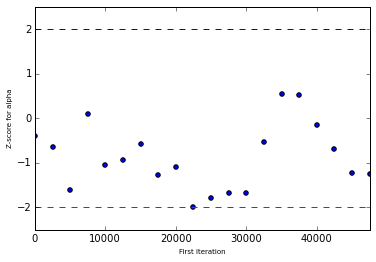

In [75]:
d = geweke(M.d,intervals=20)
Matplot.geweke_plot(d,'alpha')

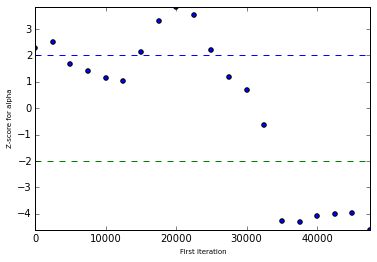

In [76]:
d = geweke(M.tau,intervals=20)
Matplot.geweke_plot(d,'alpha')

We get results that do not look better on visual inspection.

In [77]:
M = MCMC(meta_analysis())
M.sample(2000)
M.sample(2000)
M.sample(2000)
gelman_rubin(M)

 [-----------------100%-----------------] 2000 of 2000 complete in 5.0 sec

{'d': 1.1404798988039784,
 'delta': 1.0020465156908578,
 'm': 1.0051781027645512,
 'mu_0': 1.0031714489048298,
 'mu_1': 1.0022342364518779,
 'mu_10': 1.0192528674096992,
 'mu_11': 1.0017916107323859,
 'mu_12': 0.99956630241470623,
 'mu_13': 1.0084737940388169,
 'mu_14': 0.99974723068724569,
 'mu_15': 1.0009487924728049,
 'mu_16': 1.0011903032355562,
 'mu_17': 1.0007888311501438,
 'mu_18': 1.0119044413983143,
 'mu_19': 1.0060277545518852,
 'mu_2': 1.0003869652030748,
 'mu_20': 0.99970937350802525,
 'mu_21': 1.0083255325710916,
 'mu_3': 1.0039134091779609,
 'mu_4': 0.99997595731157785,
 'mu_5': 1.002215607886825,
 'mu_6': 1.0116065515501806,
 'mu_7': 1.0082941607841753,
 'mu_8': 1.0053494988280482,
 'mu_9': 1.011372760809212,
 'p_c': [1.0043735123612689,
  1.002410698100433,
  1.0006101223908663,
  1.0063386984610192,
  1.0004913117705105,
  1.001804012246015,
  1.0113739250971825,
  1.0079261273315452,
  1.0026501698160506,
  1.0045096593095013,
  1.0150691461899555,
  1.002080324674687

The score for $\tau$ does not show a lot of improvement by using the Gelman-Rubin diagnostic.

In [78]:
def meta_analysis_gof():
    ###priors on d and tau
    m = mc.Normal('m', 0, 0.00001, value = 0)
    s = mc.Normal('s',0, 0.00001, value = 1)

    ###priors on d and t
    d = mc.Normal('d', 0, 0.00001, value = 0)
    tau = mc.Gamma('t',0.0001, 0.0001, value = 1)

    #priors on mu and delta
    mu = [mc.Normal('mu_{}'.format(str(i)), m, s, value=0.) for i in range(N)]
    delta = [mc.Normal('delta', d, tau, value=0.)]

    #p_c = mc.Lambda('p_c', lambda mu=mu: mc.invlogit(mu))
    @mc.deterministic
    def p_c(mu=mu):
        return mc.invlogit(mu)
    p_t = mc.Lambda('p_t', lambda mu=mu, delta=delta: mc.invlogit(np.array(mu)+delta))


    ### likelihood
    r_c = mc.Binomial('r_c', n_c_obs, p_c, value=r_c_obs, observed=True)
    r_t = mc.Binomial('r_t', n_t_obs, p_t, value=r_t_obs, observed=True)
    
    r_c_Simulated = mc.Binomial('r_c', n_c_obs, p_c)
    r_t_Simulated = mc.Binomial('r_t', n_t_obs, p_t)
    
    return locals()

In [79]:

M_gof = MCMC(meta_analysis_gof())
M_gof.sample(10000,burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 32.0 sec

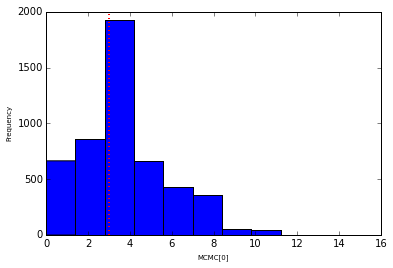

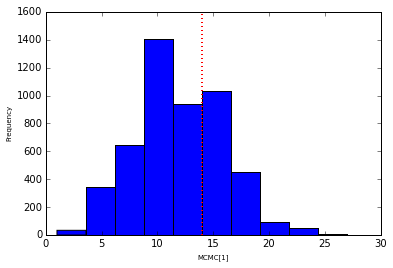

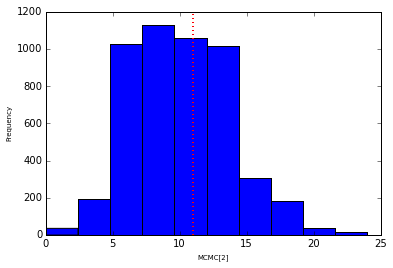

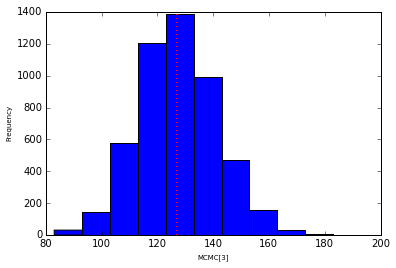

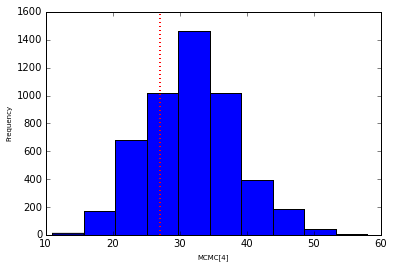

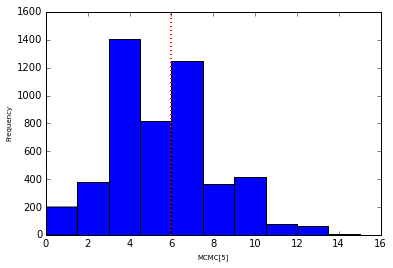

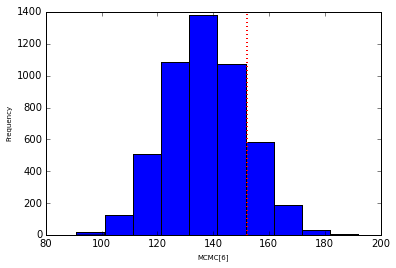

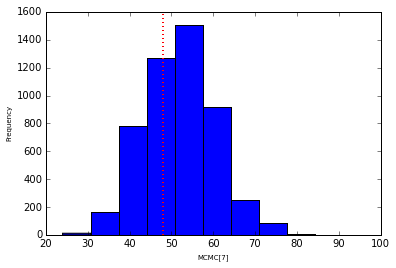

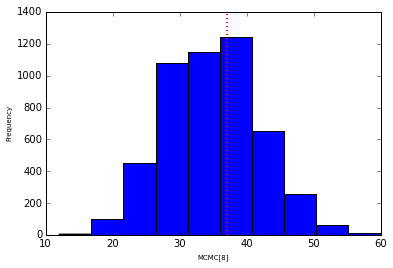

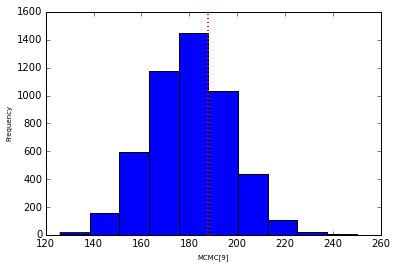

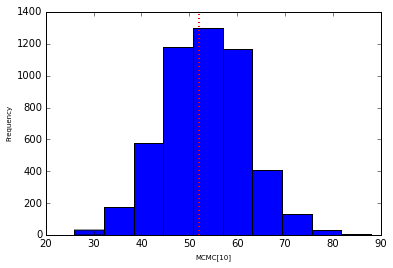

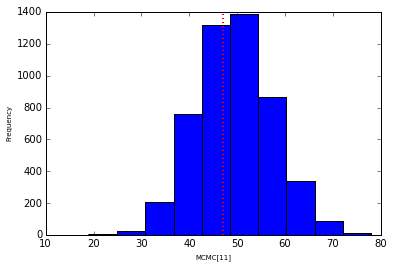

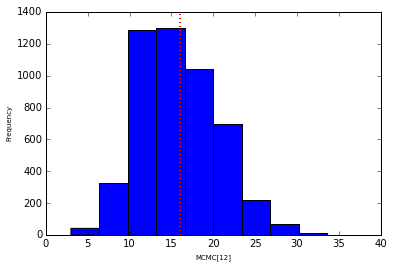

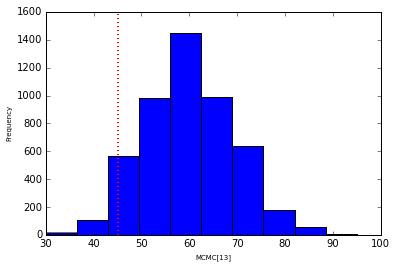

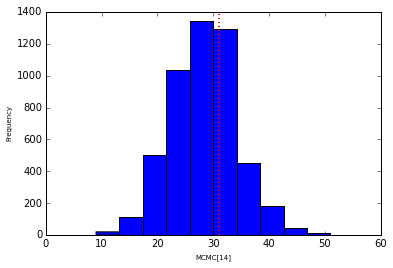

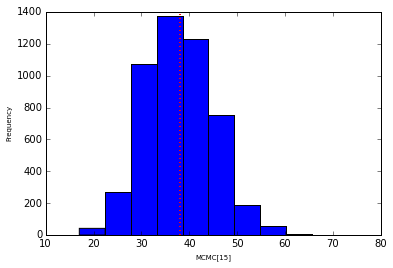

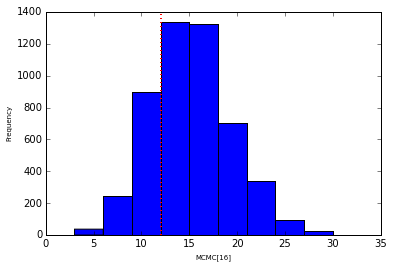

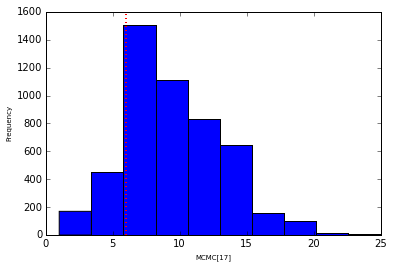

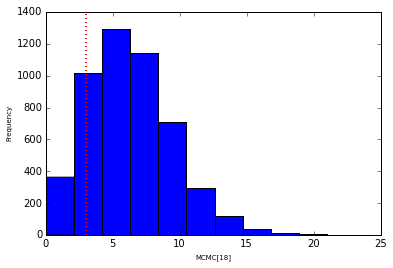

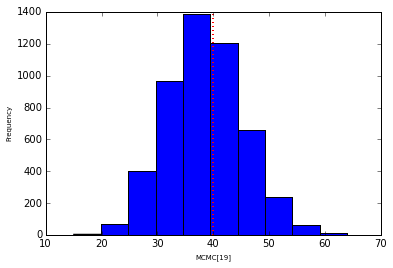

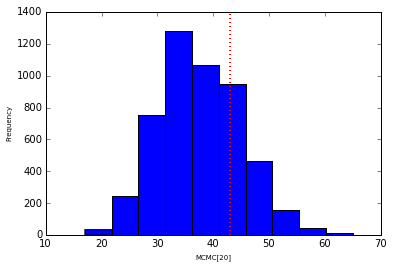

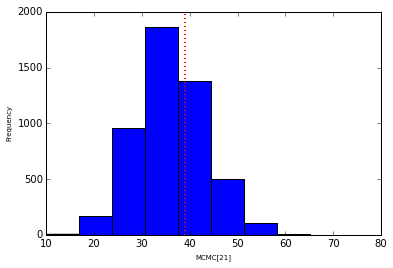

In [80]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_c_Simulated.trace(), r_c_obs, bins=10)

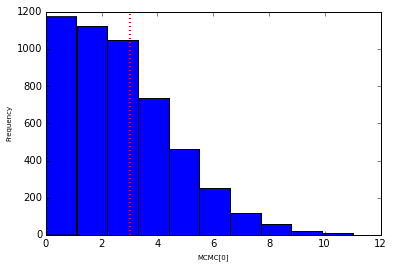

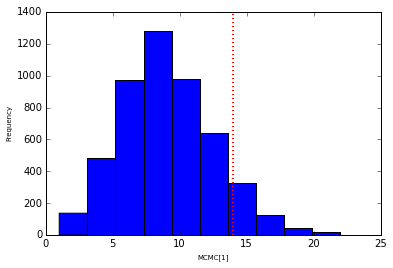

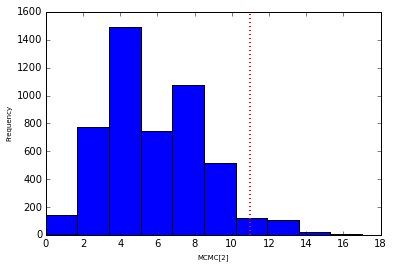

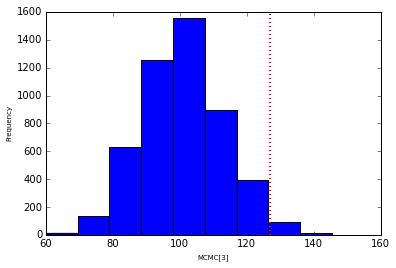

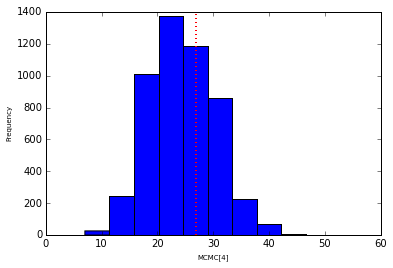

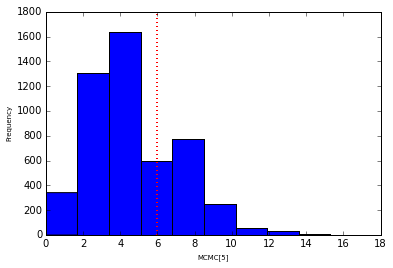

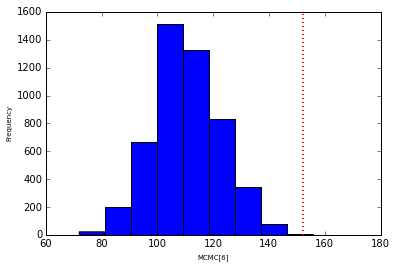

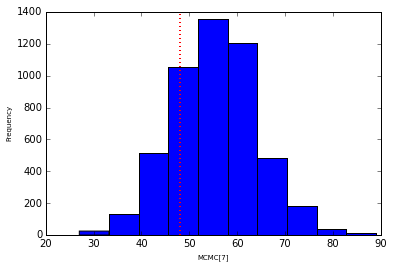

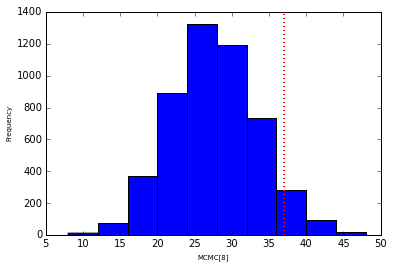

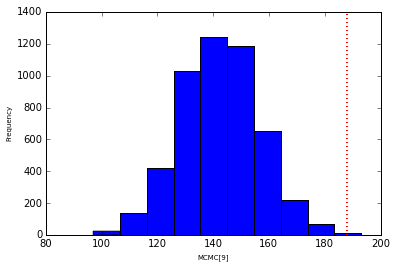

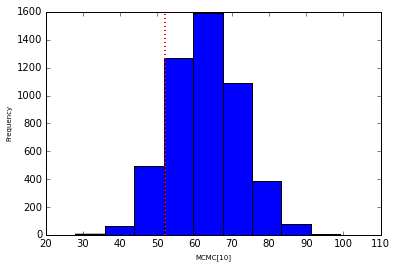

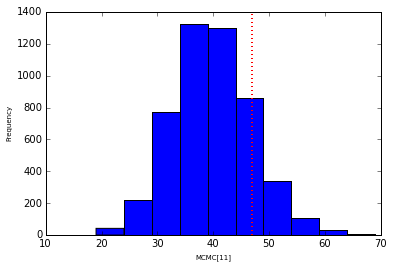

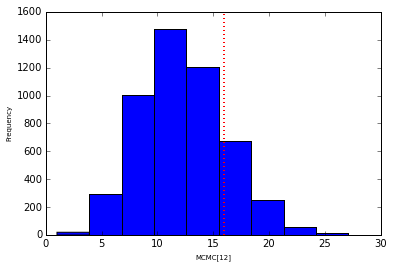

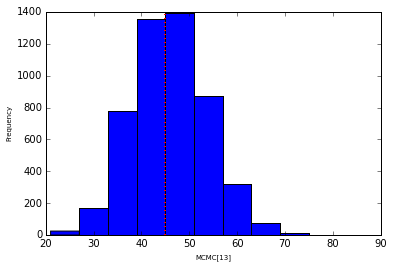

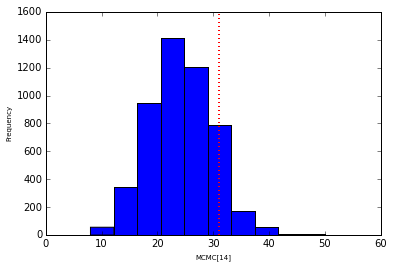

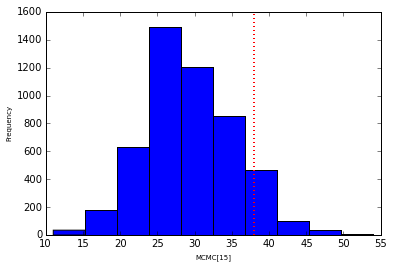

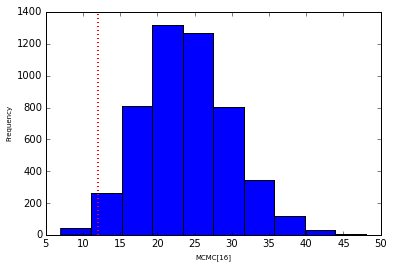

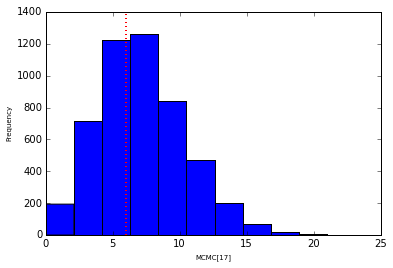

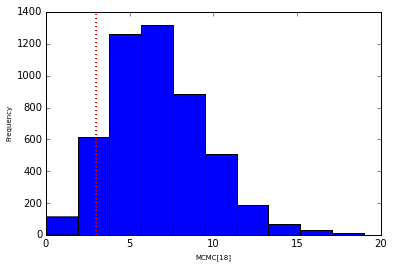

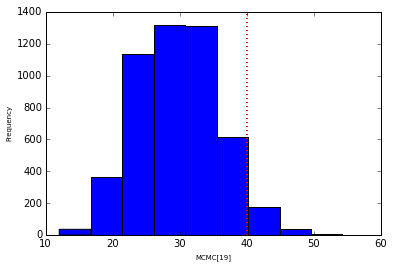

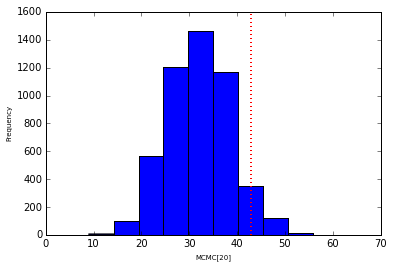

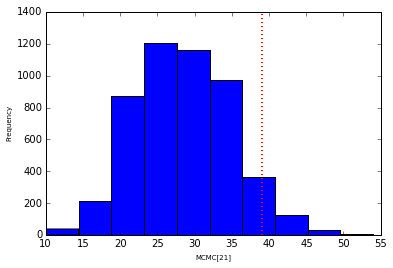

In [81]:
#Check goodness of fit with respect to r_c
Matplot.gof_plot(M_gof.r_t_Simulated.trace(), r_c_obs, bins=10)

In [82]:
M.DIC

284.8713362314586

We simulate data from our fitted model and compare it with the original data that gives us positive results despite certain deviations.

Comparison of DIC Scores:
    
1. Random Effect for population effect only: 287.04

2. Random Effect for treatment effect only: 285.42

3. Fixed Effect for population effect and treatment effect: 287.66

4. Random Effect for population effect and treatment effect: 284.87

We see that a random effect for population and a fixed effect for treatment performs the best in this case.

## The reason the DIC scores are so similar is that you ahve essentially fit the same model 4 times.

## 21/25

## Overall: 42/50